This analysis seeks to find ways to draw the inner contour based on just the outer contour.

In [93]:
# import packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.insert(0,r'../')

import ast

from epochs import create_epoch, create_file_info_df, parse_dicom_file, parse_contour_file, poly_to_mask

In [69]:
# function and test to compute average intensity

def compute_average_intensity(img,mask):
    return float(np.sum(np.multiply(img,mask)))/float(np.sum(mask))

def test_compute_average_intensity():
    img = np.zeros((50,50))
    img[10:20,10:20] = 100
    img[10:20,10:15] = 5
    mask = img>50
    return compute_average_intensity(img,mask)

test_compute_average_intensity()

100.0

In [71]:
# load the file containing the filepaths to the images and the 
# coordinates of the inner and outer contours (generated using epochs.py)

file_info = pd.read_csv('../testing/file_info.csv')
file_info.head()

Unnamed: 0                dicom_file_name_with_path  \
0           0   ../final_data/dicoms/SCD0000101/59.dcm   
1           0   ../final_data/dicoms/SCD0000101/79.dcm   
2           0   ../final_data/dicoms/SCD0000101/99.dcm   
3           0  ../final_data/dicoms/SCD0000101/119.dcm   
4           0  ../final_data/dicoms/SCD0000101/139.dcm   

                       i_contour_file_name_with_path  \
0  ../final_data/contourfiles/SC-HF-I-1/i-contour...   
1  ../final_data/contourfiles/SC-HF-I-1/i-contour...   
2  ../final_data/contourfiles/SC-HF-I-1/i-contour...   
3  ../final_data/contourfiles/SC-HF-I-1/i-contour...   
4  ../final_data/contourfiles/SC-HF-I-1/i-contour...   

                                            i_coords  image_num  \
0  [(130.5, 118.0), (131.0, 118.0), (131.5, 117.5...         59   
1  [(130.0, 114.5), (130.5, 114.5), (131.0, 114.5...         79   
2  [(135.5, 114.0), (136.0, 114.0), (136.5, 114.0...         99   
3  [(130.0, 113.5), (130.5, 113.5), (131.0, 113.5...        119   
4  [(139.0, 116.5), (139.5, 116.5), (140.0, 117.0...        139   

                       o_contour_file_name_with_path  \
0  ../final_data/contourfiles/SC-HF-I-1/o-contour...   
1  ../final_data/contourfiles/SC-HF-I-1/o-contour...   
2  ../final_data/contourfiles/SC-HF-I-1/o-contour...   
3  ../final_data/contourfiles/SC-HF-I-1/o-contour...   
4  ../final_data/contourfiles/SC-HF-I-1/o-contour...   

                                            o_coords original_id  patient_id  \
0  [(119.0, 140.0), (118.5, 139.5), (118.5, 139.0...   SC-HF-I-1  SCD0000101   
1  [(127.0, 109.0), (127.5, 109.0), (128.0, 109.0...   SC-HF-I-1  SCD0000101   
2  [(137.0, 162.0), (137.0, 162.5), (137.5, 163.0...   SC-HF-I-1  SCD0000101   
3  [(114.5, 113.0), (115.0, 112.5), (115.5, 112.5...   SC-HF-I-1  SCD0000101   
4  [(156.5, 140.5), (156.5, 141.0), (156.0, 141.5...   SC-HF-I-1  SCD0000101   

   patient_num  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0

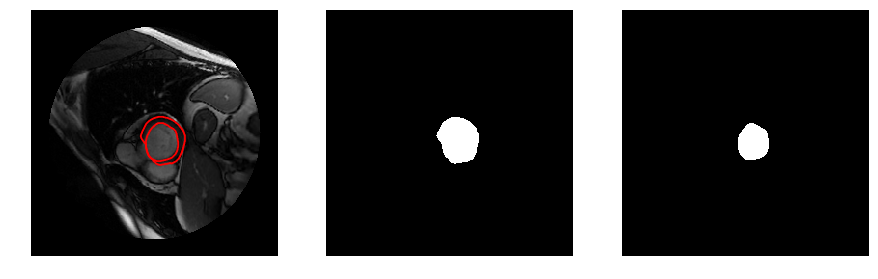

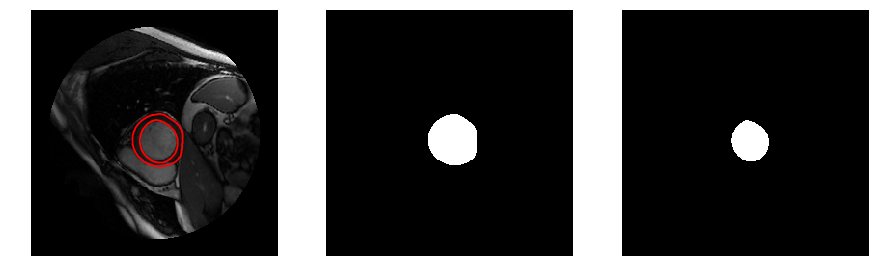

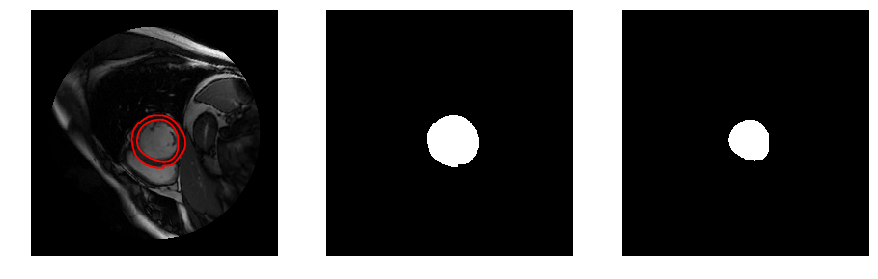

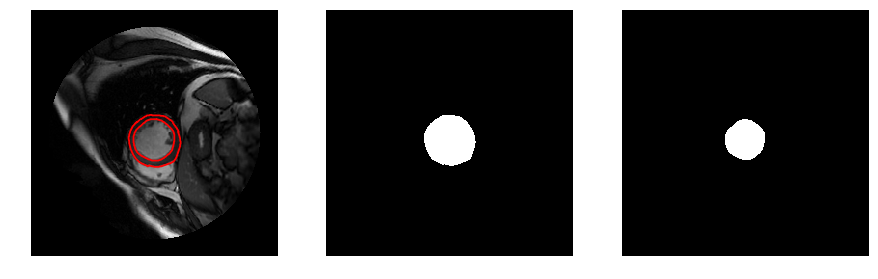

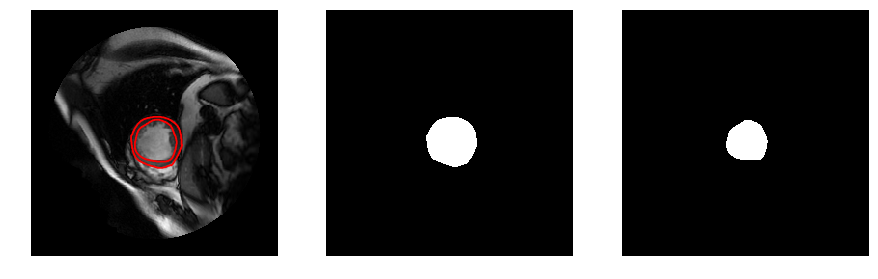

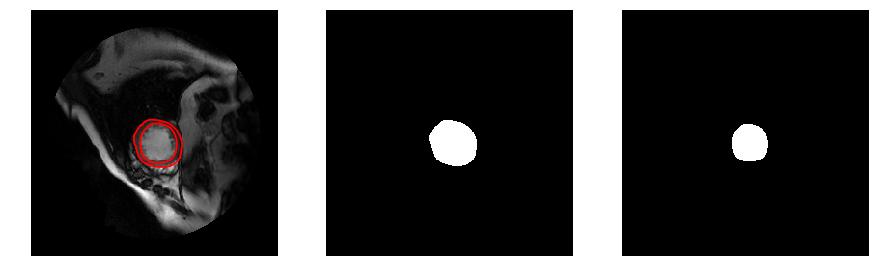

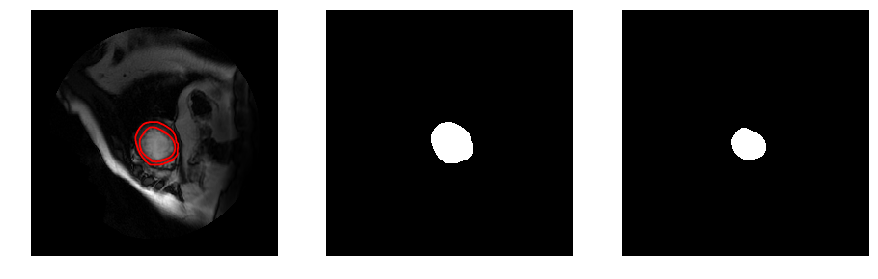

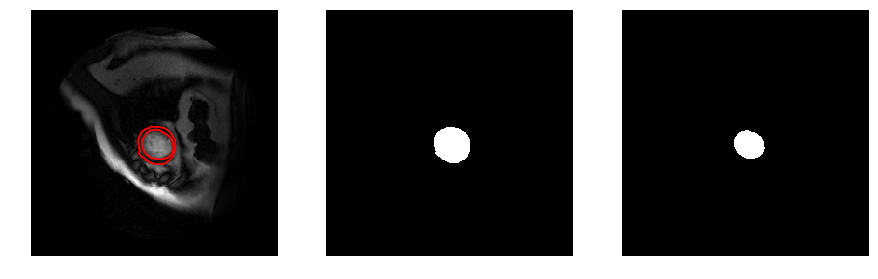

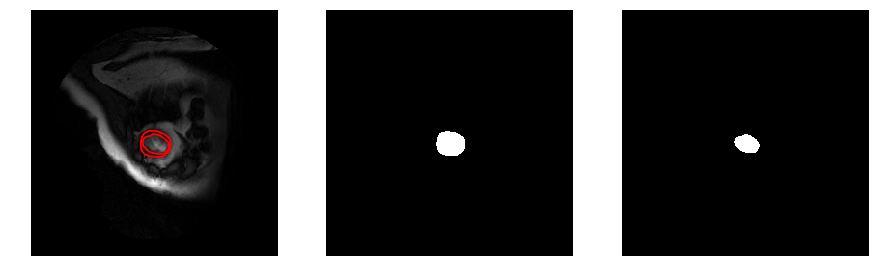

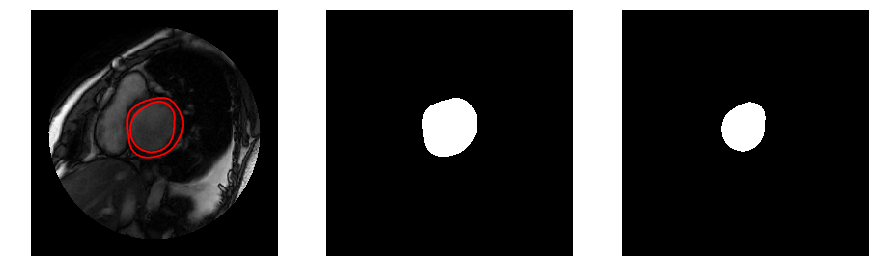

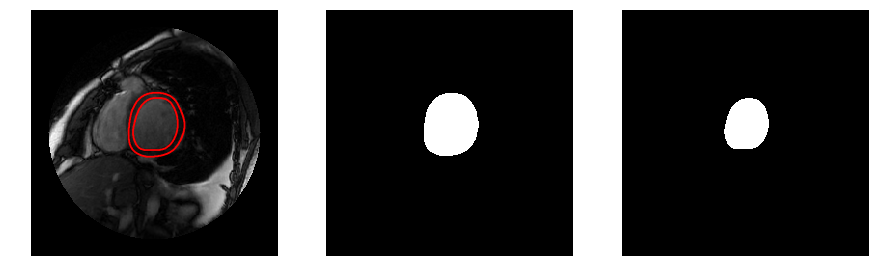

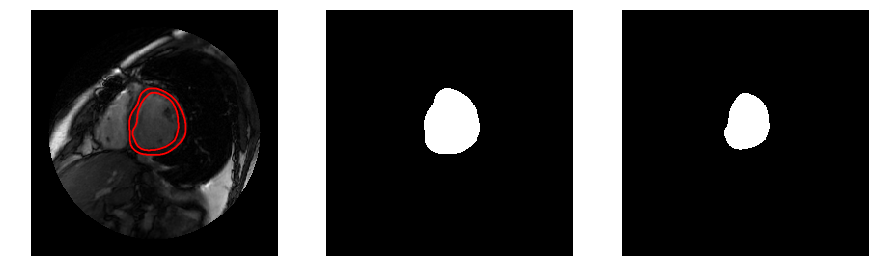

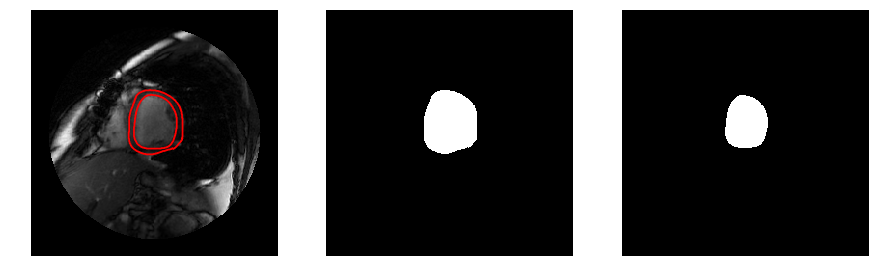

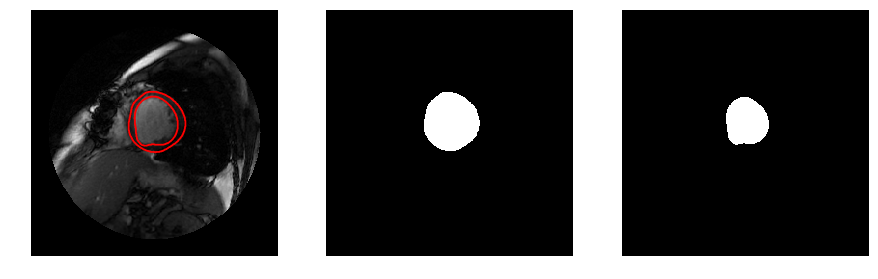

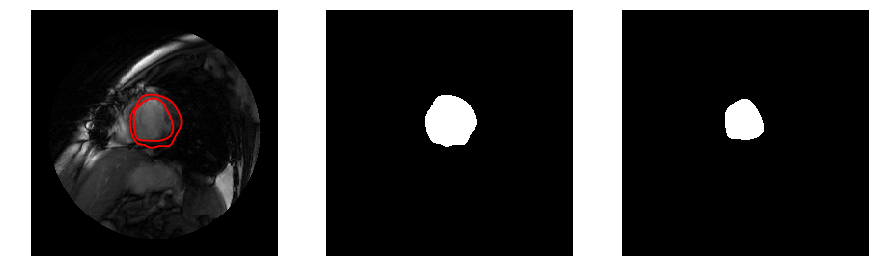

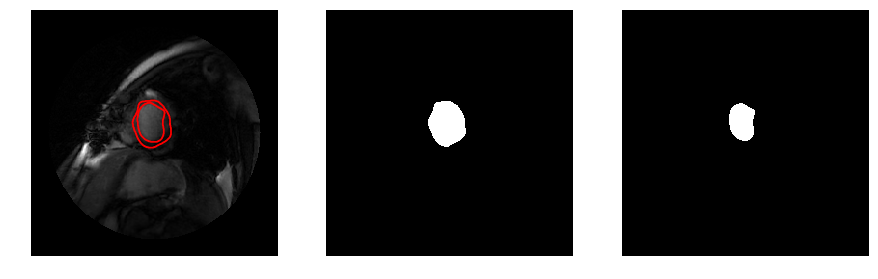

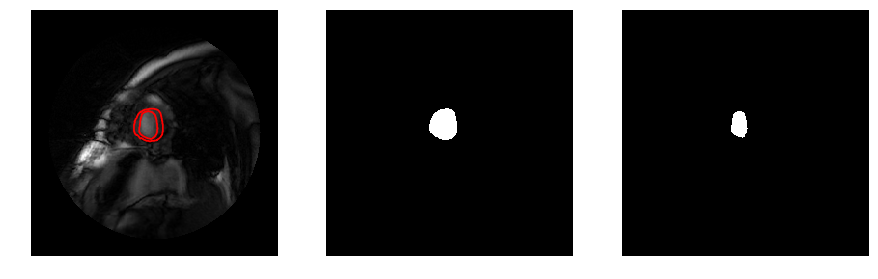

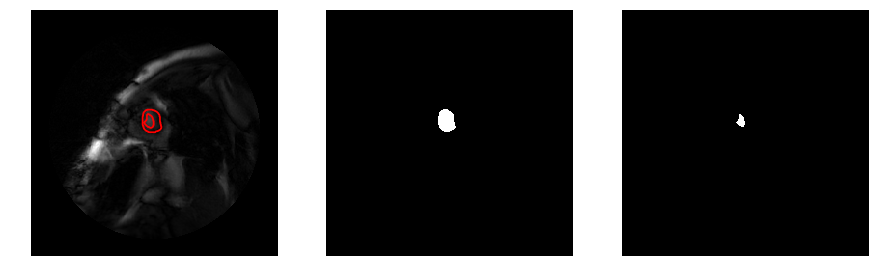

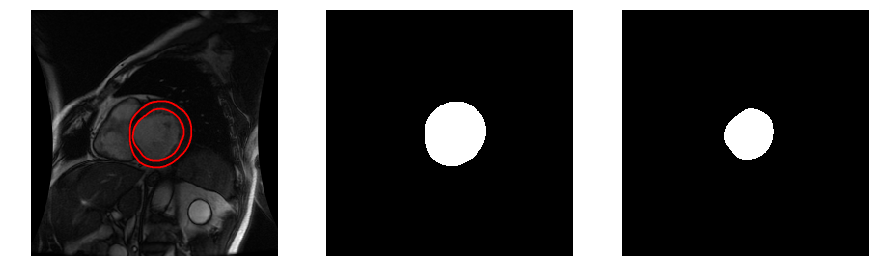

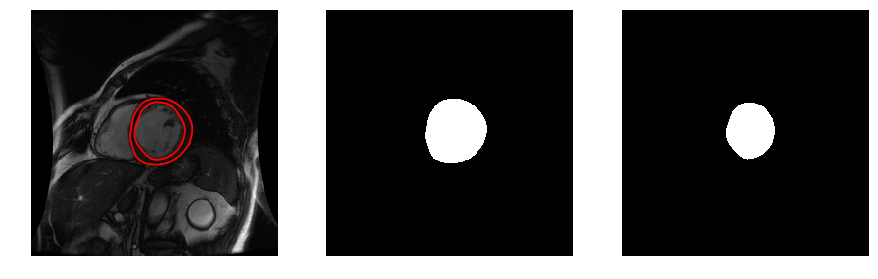

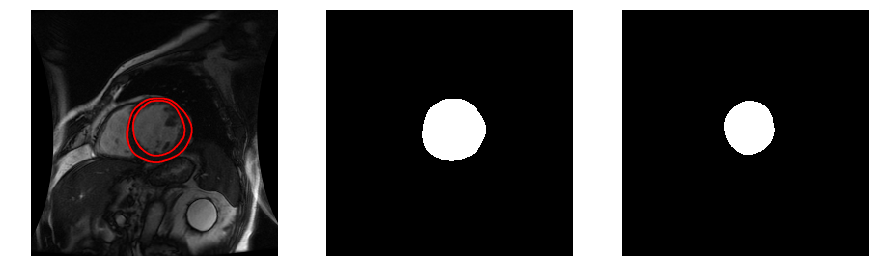

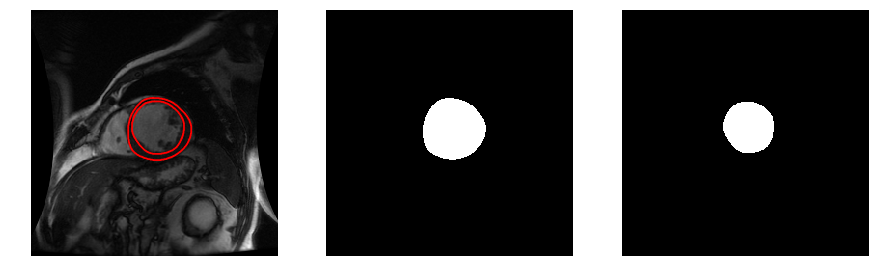

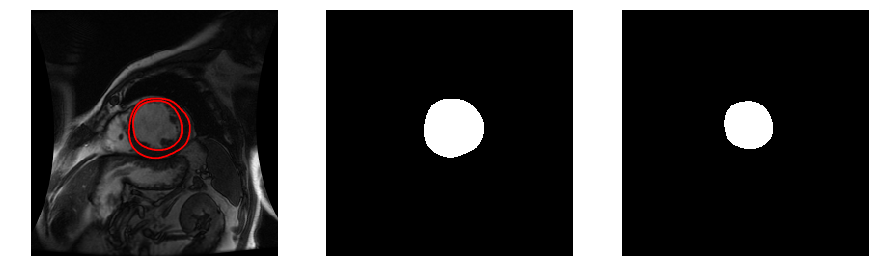

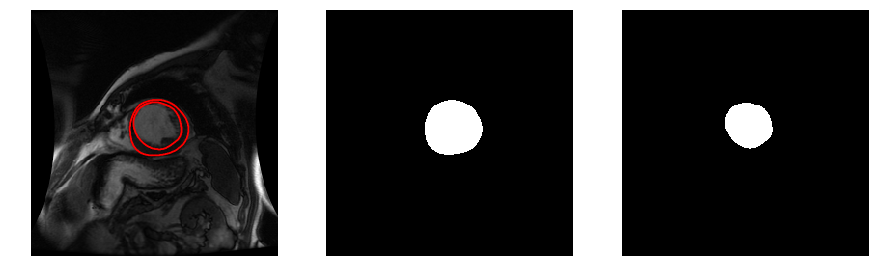

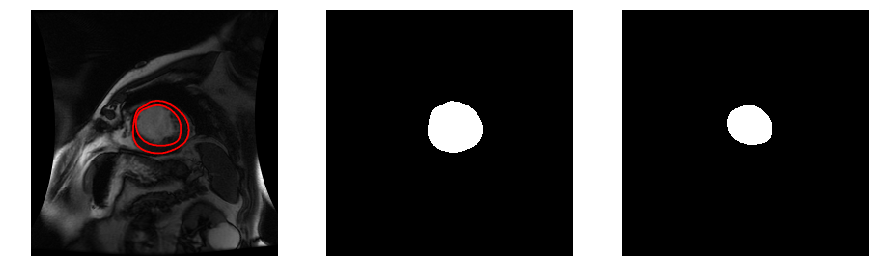

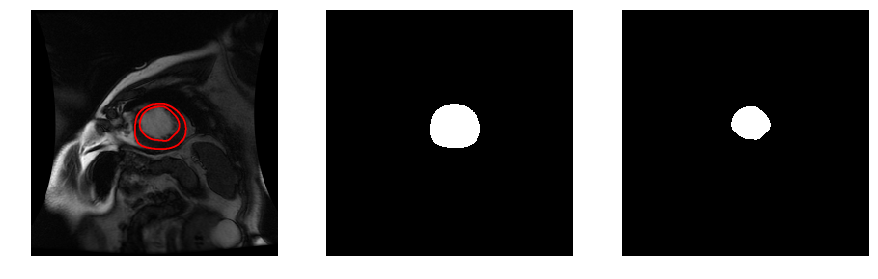

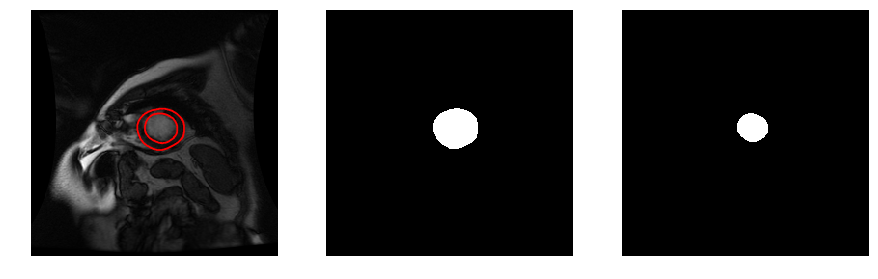

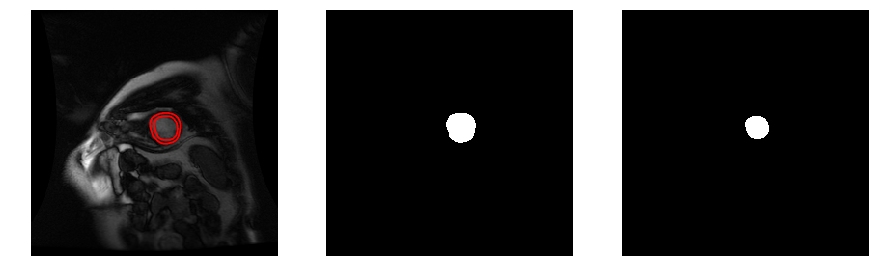

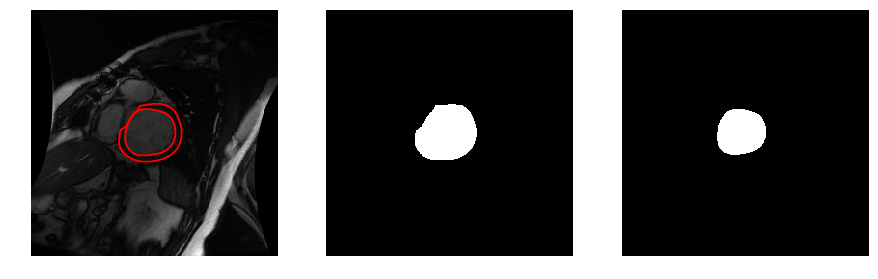

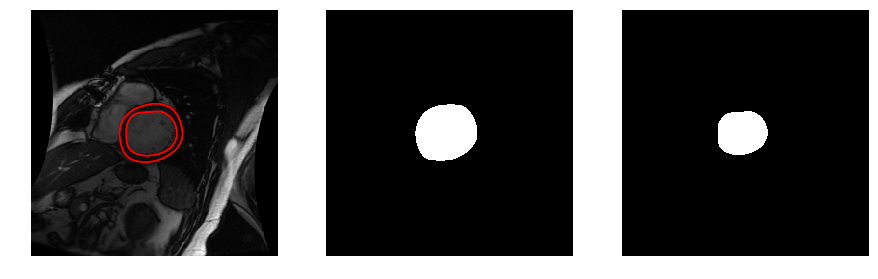

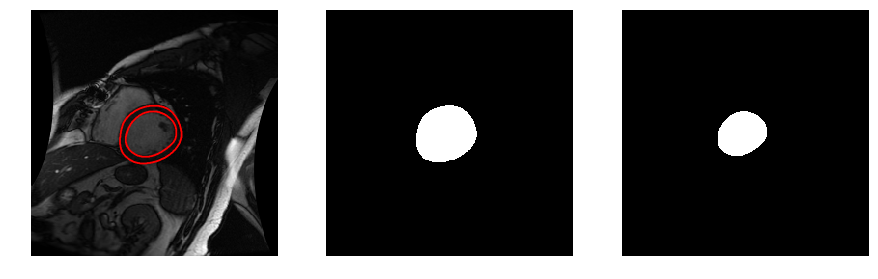

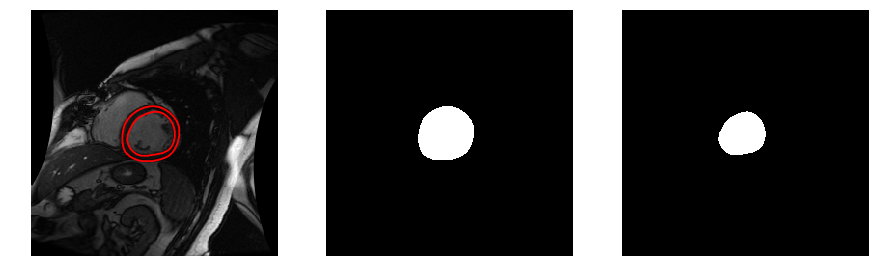

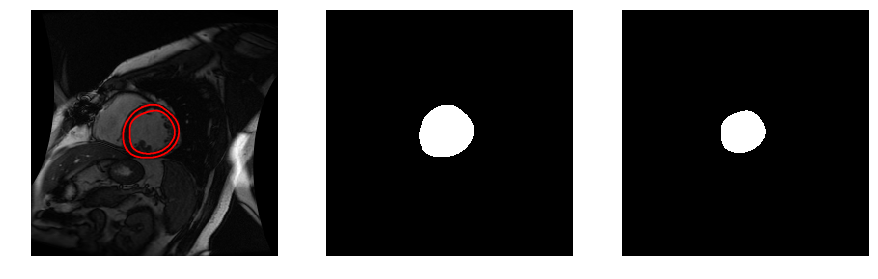

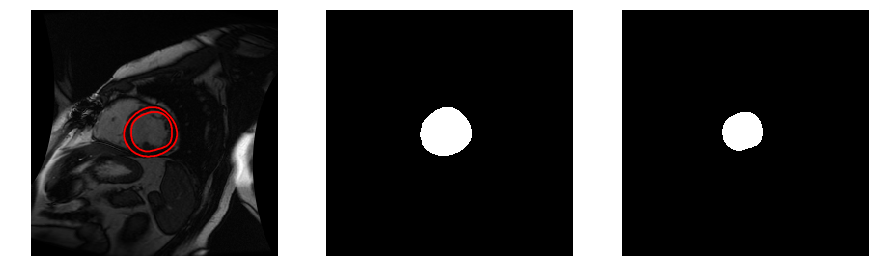

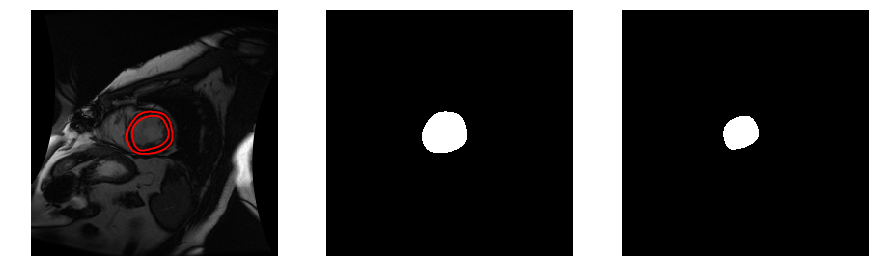

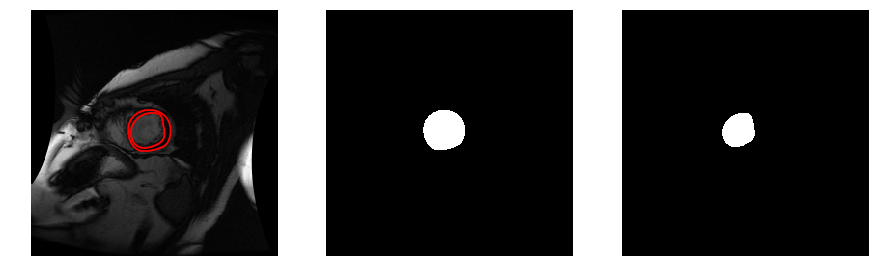

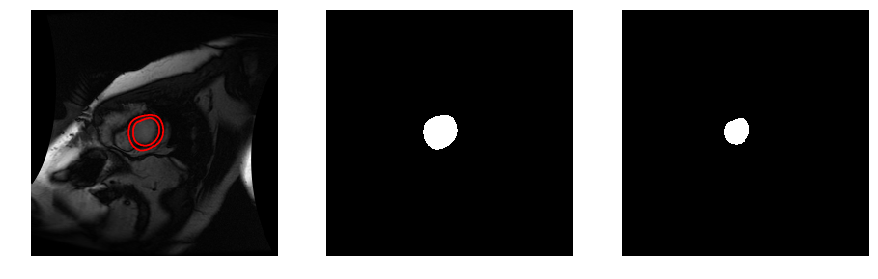

In [74]:
# plot the inner and outer contours

for idx, row in file_info.iterrows():
    dicom_img = parse_dicom_file(row.dicom_file_name_with_path)
    o_coords = ast.literal_eval(row.o_coords)
    i_coords = ast.literal_eval(row.i_coords)
    img_mask_o = poly_to_mask(o_coords, dicom_img.shape[0], dicom_img.shape[1])
    img_mask_i = poly_to_mask(i_coords, dicom_img.shape[0], dicom_img.shape[1])
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(dicom_img, cmap='gray')
    ax[0].plot(np.array(o_coords)[:, 0], np.array(o_coords)[:, 1], 'r')
    ax[0].plot(np.array(i_coords)[:, 0], np.array(i_coords)[:, 1], 'r')
    ax[0].axis('off')
    ax[1].imshow(img_mask_o.astype(int), cmap='gray')
    ax[1].axis('off')
    ax[2].imshow(img_mask_i.astype(int), cmap='gray')
    ax[2].axis('off')
    plt.show()
    #plt.savefig(os.path.join(saved_images_dir, 'patient' + str(row.patient_id) + 'image' + str(int(row.image_num)) + '.png'))
    #plt.close()
    


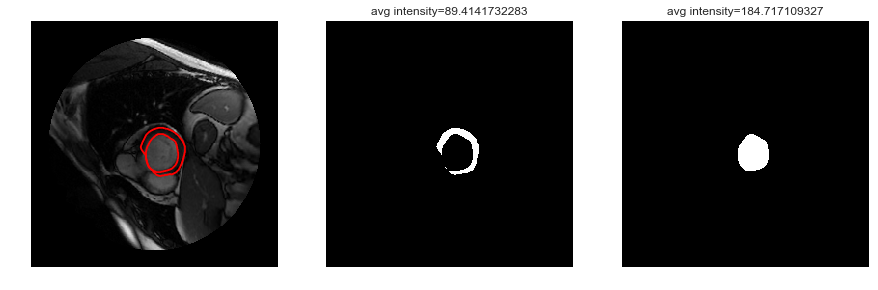

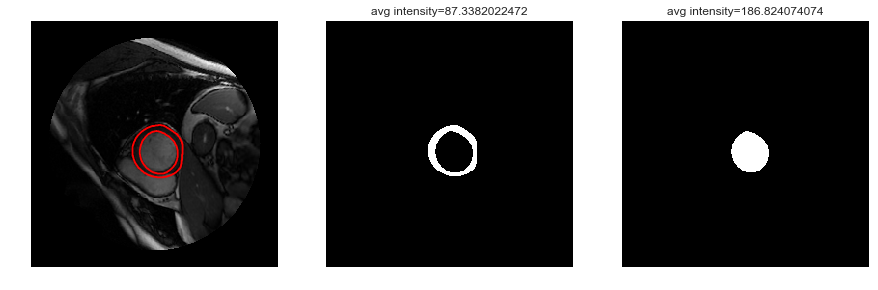

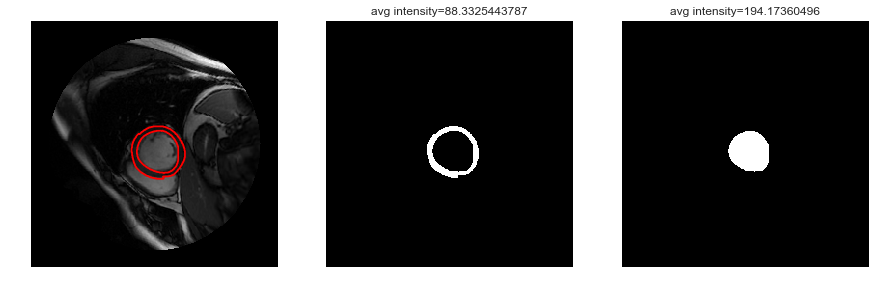

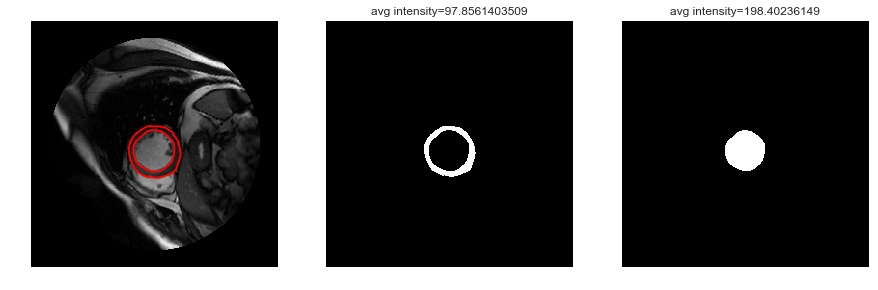

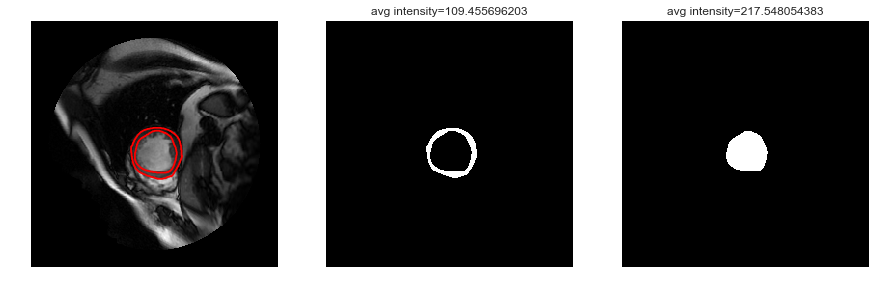

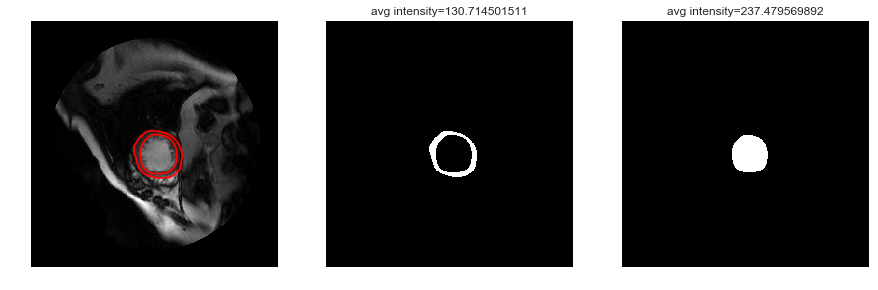

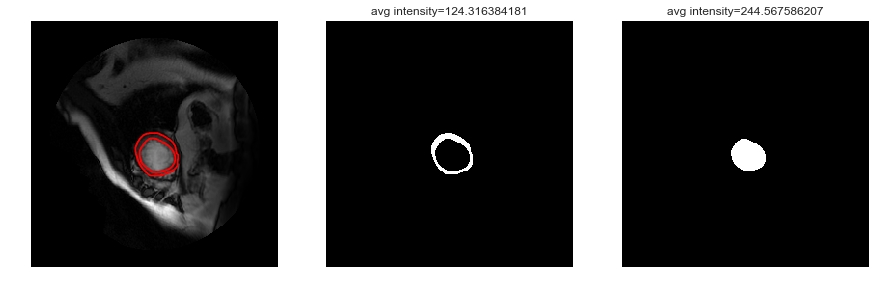

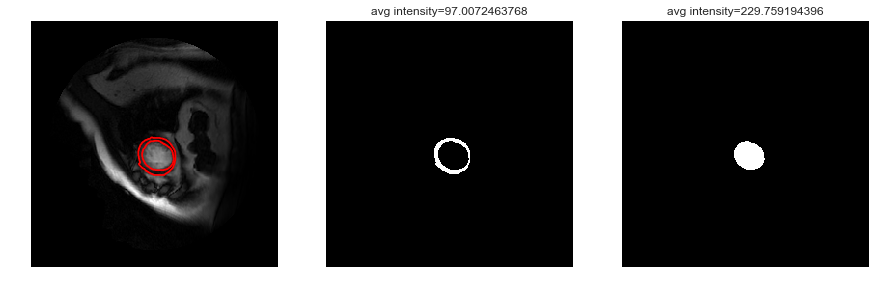

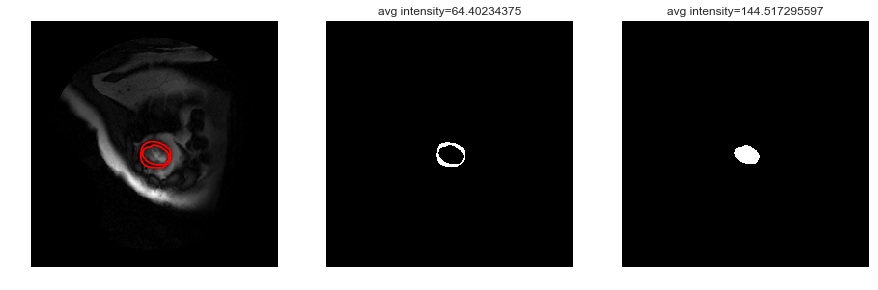

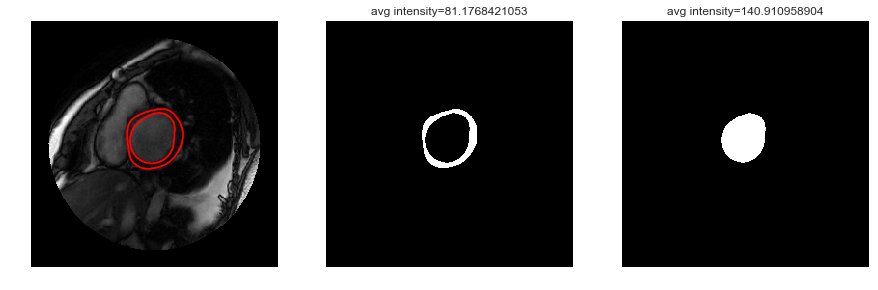

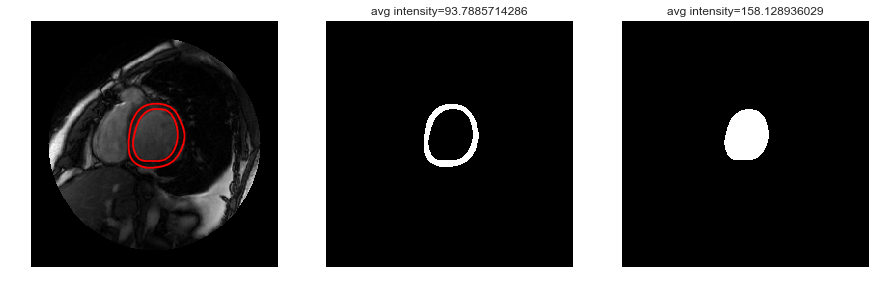

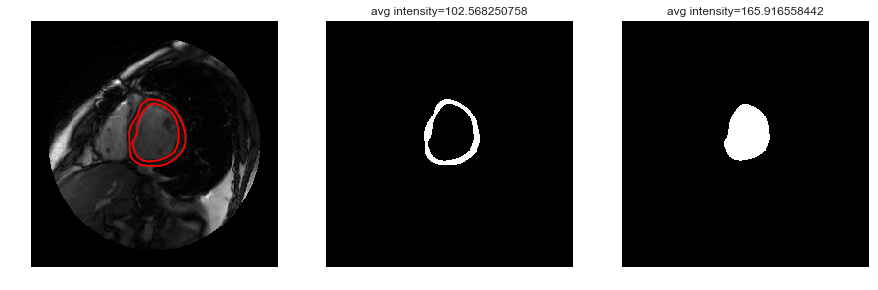

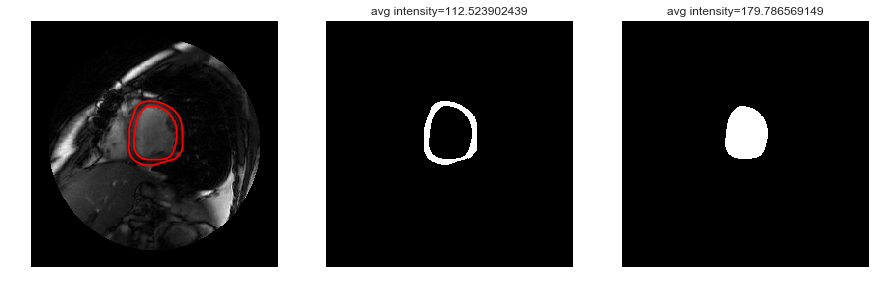

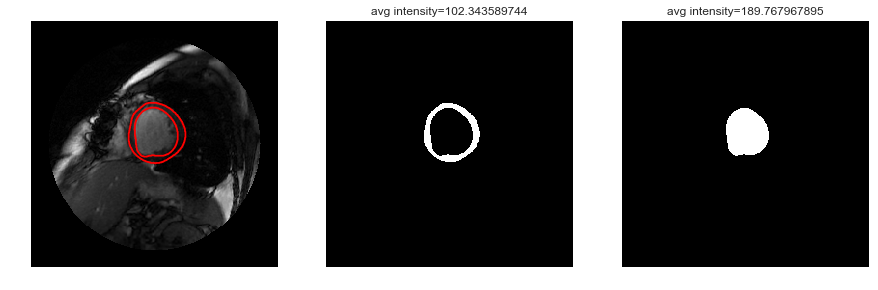

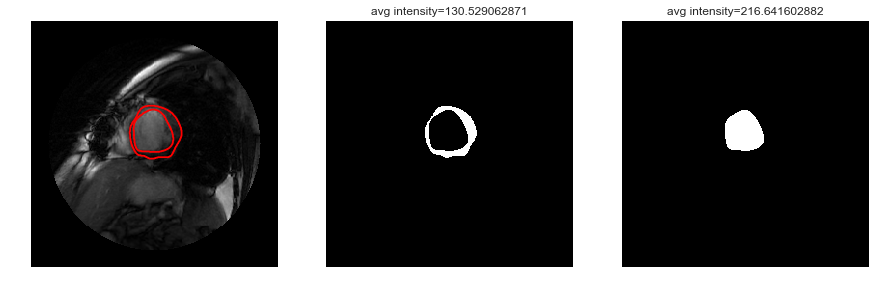

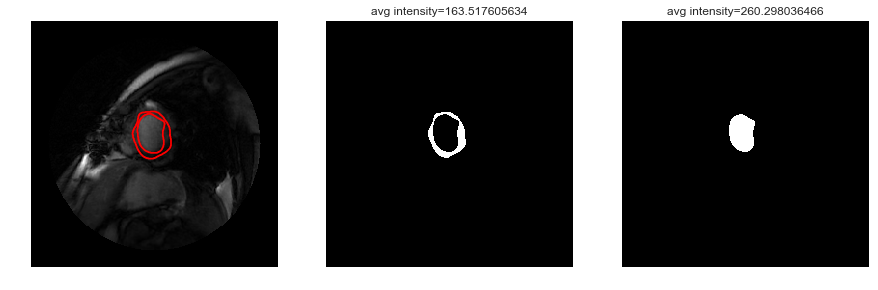

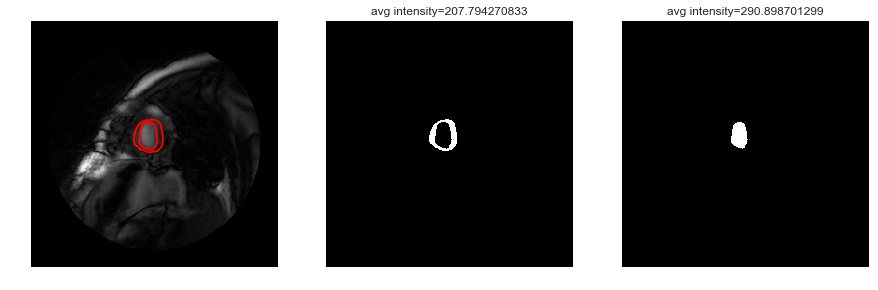

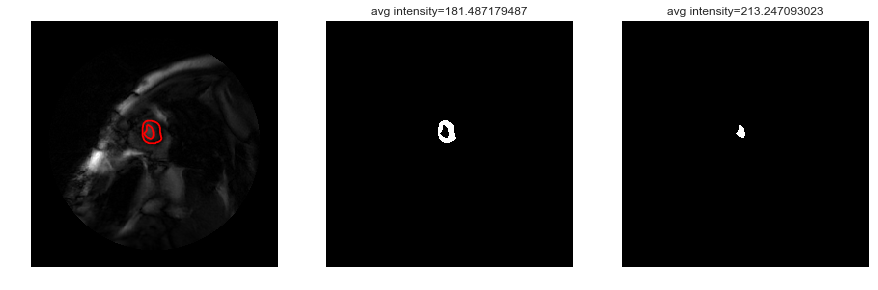

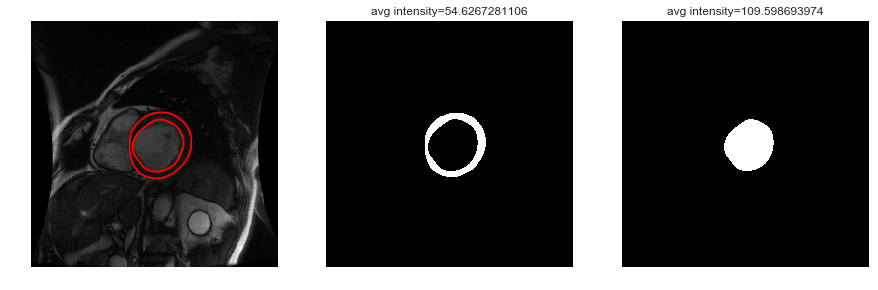

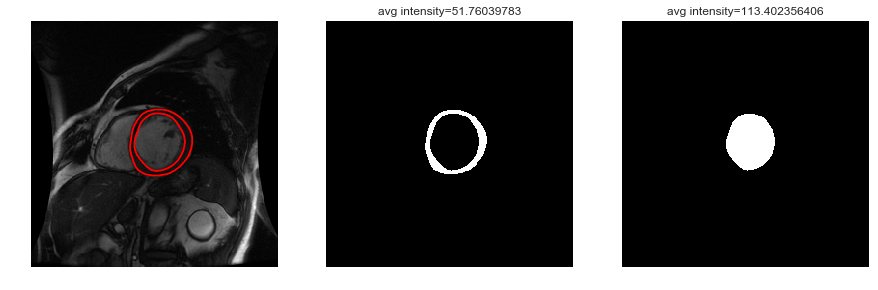

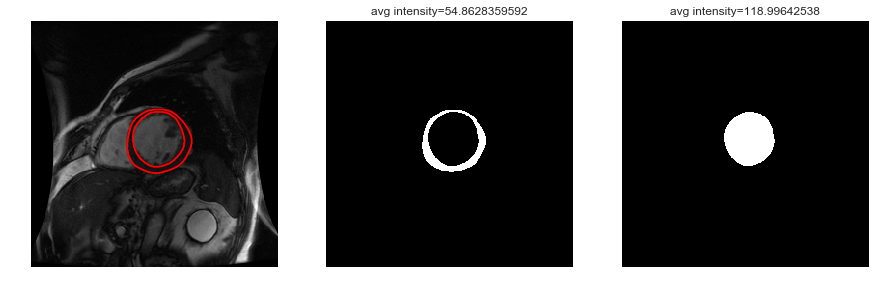

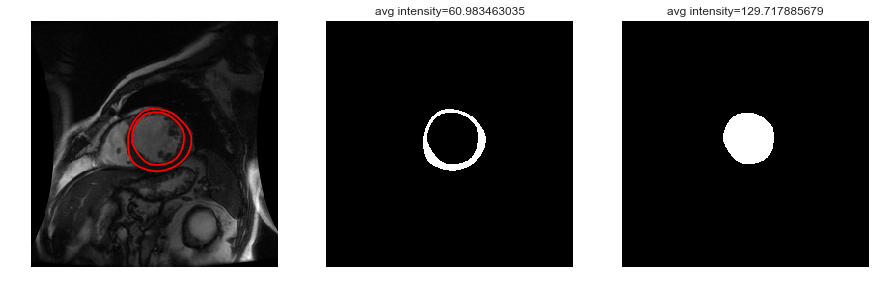

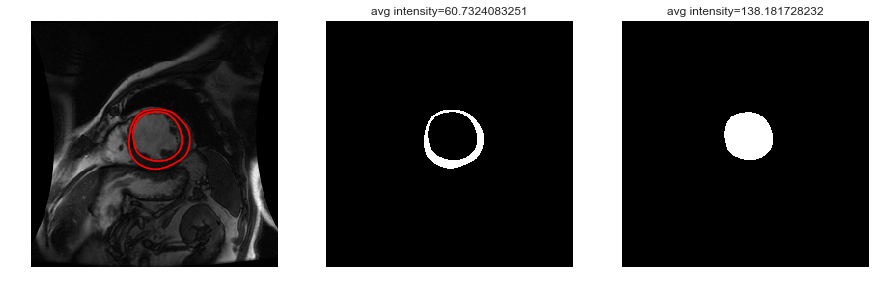

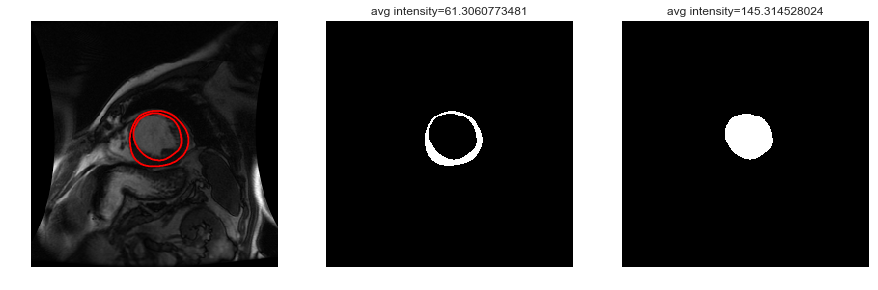

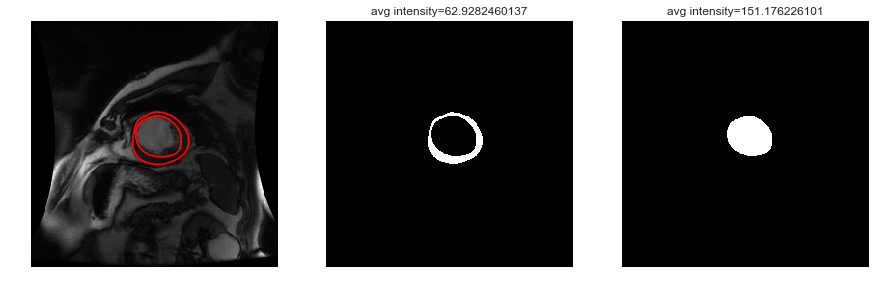

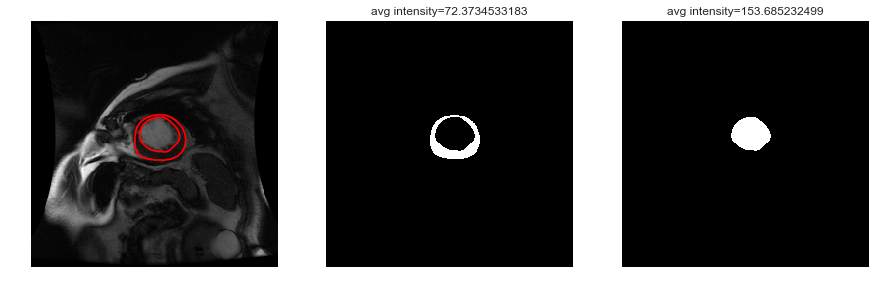

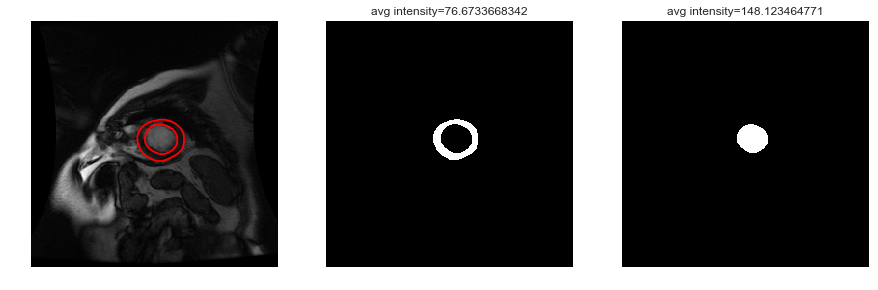

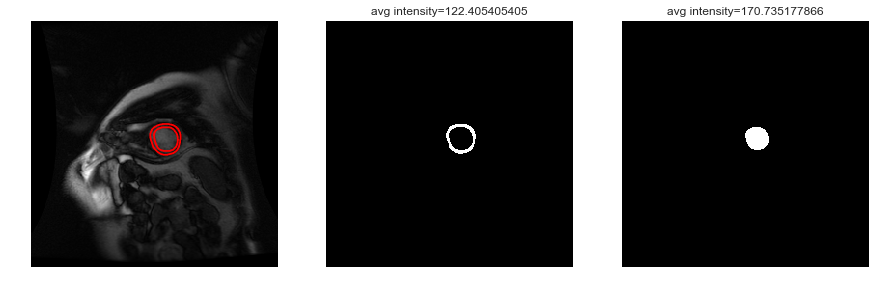

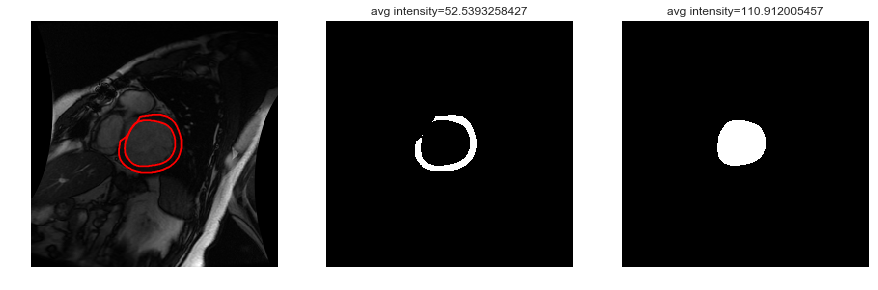

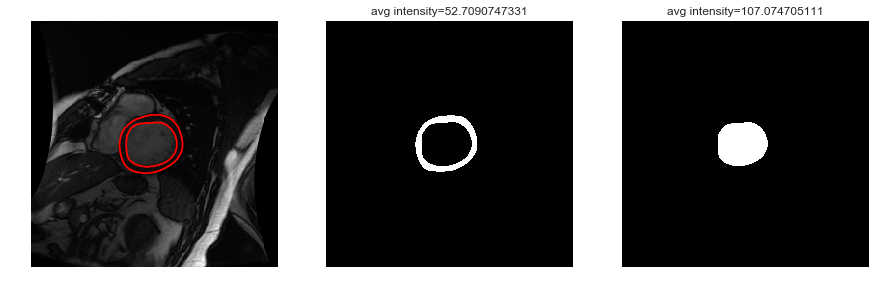

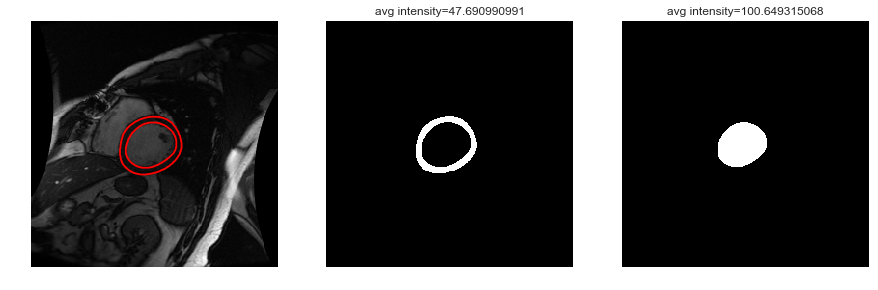

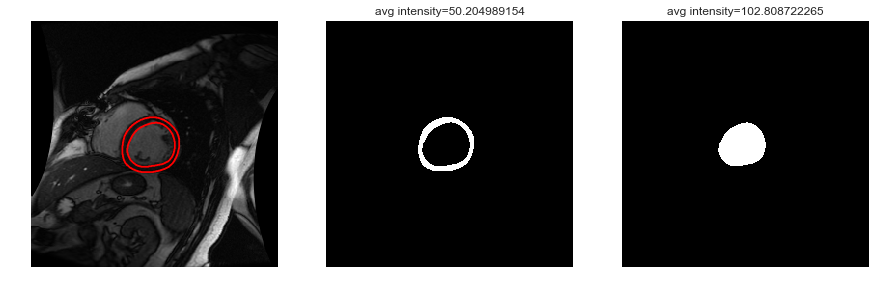

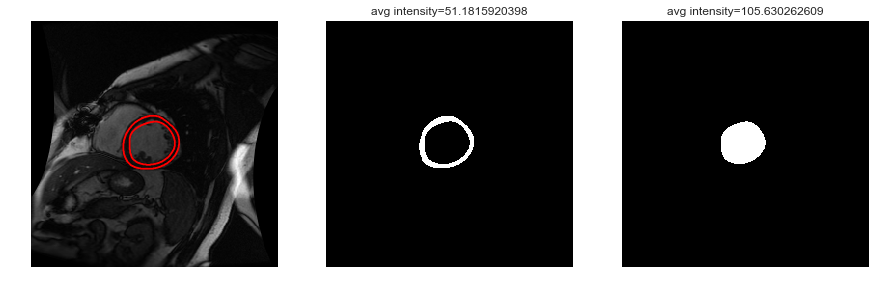

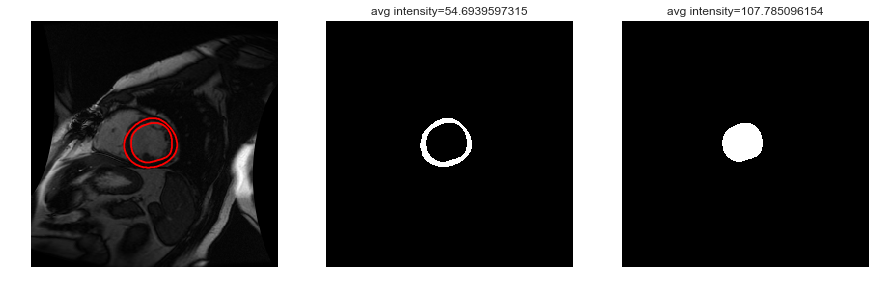

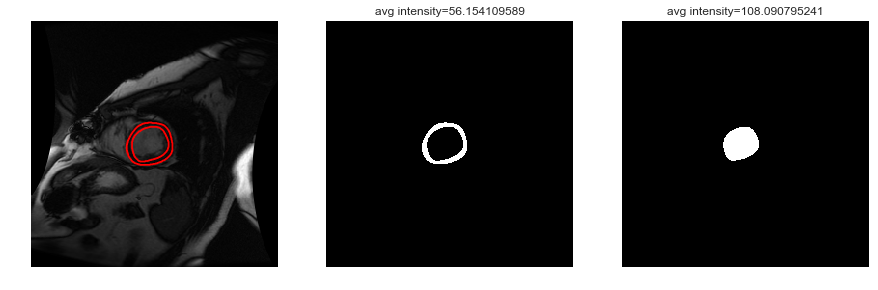

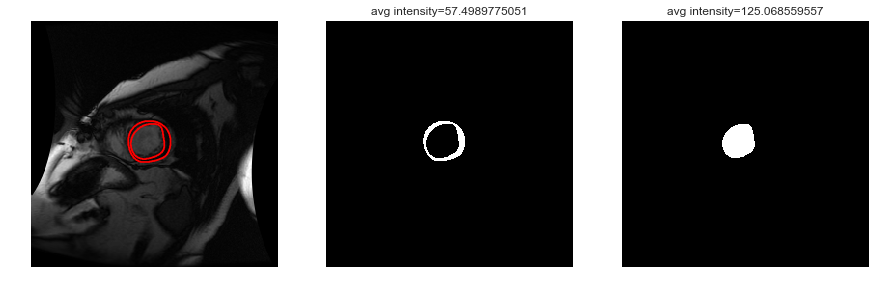

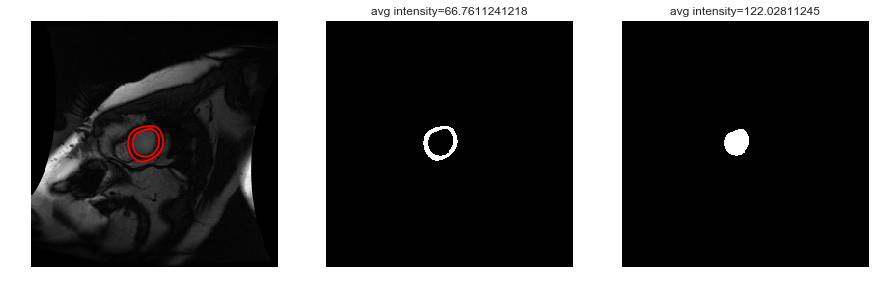

In [92]:
# compute the inner and outer intensities

all_intensities_muscle = []
all_intensities_pool = []
intensities_muscle = []
intensities_pool = []

for idx, row in file_info.iterrows():
    dicom_img = parse_dicom_file(row.dicom_file_name_with_path)
    o_coords = ast.literal_eval(row.o_coords)
    i_coords = ast.literal_eval(row.i_coords)
    img_mask_o = poly_to_mask(o_coords, dicom_img.shape[0], dicom_img.shape[1])
    img_mask_i = poly_to_mask(i_coords, dicom_img.shape[0], dicom_img.shape[1])
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(dicom_img, cmap='gray')
    ax[0].plot(np.array(o_coords)[:, 0], np.array(o_coords)[:, 1], 'r')
    ax[0].plot(np.array(i_coords)[:, 0], np.array(i_coords)[:, 1], 'r')
    ax[0].axis('off')
    diff_mask = img_mask_o.astype(int)-img_mask_i.astype(int)
    diff_mask[diff_mask<0] = 0
    diff_mask[diff_mask>1] = 1
    ax[1].imshow(diff_mask, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('avg intensity='+ str(compute_average_intensity(dicom_img,diff_mask)))
    ax[2].imshow(img_mask_i.astype(int), cmap='gray')
    ax[2].axis('off')
    ax[2].set_title('avg intensity='+ str(compute_average_intensity(dicom_img,img_mask_o.astype(int))))
    
    intensities_muscle.append(compute_average_intensity(dicom_img,diff_mask))
    intensities_pool.append(compute_average_intensity(dicom_img,img_mask_o.astype(int)))
    
    all_intensities_muscle.extend(list(dicom_img[diff_mask.astype(bool)]))
    all_intensities_pool.extend(list(dicom_img[img_mask_o.astype(bool)]))
    
    plt.show()
    
file_info['muscle_intensities'] = intensities_muscle
file_info['pool_intensitites'] = intensities_pool

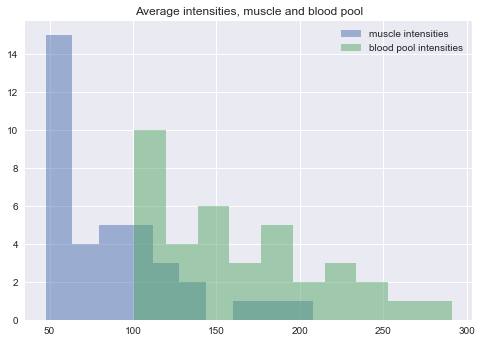

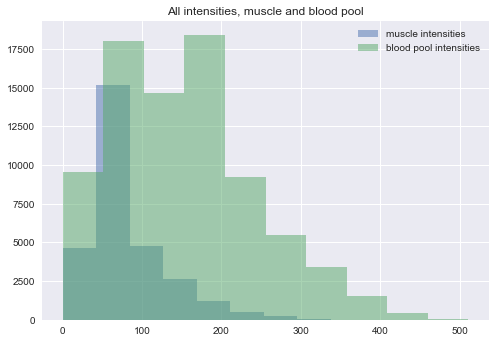

In [89]:
# plot the histograms of the average intensity inside and outside the regions

plt.hist(intensities_muscle,alpha=0.5)
plt.hist(intensities_pool,alpha=0.5)
plt.legend(['muscle intensities','blood pool intensities'])
plt.title('Average intensities, muscle and blood pool')
plt.show()

plt.hist(all_intensities_muscle,alpha=0.5)
plt.hist(all_intensities_pool,alpha=0.5)
plt.legend(['muscle intensities','blood pool intensities'])
plt.title('All intensities, muscle and blood pool')
plt.show()

The above histogram shows that a simple thresholding scheme (thresholding all of the images based on a specific pixel value in order to get the i-contour) would not be sufficient. There is considerable overlap in the average pixel intensities between the inner blood pool and outer contour, so selecting a specific value for thresholding likely wouldn't work. There is also considerable overlap between the individual pixel intensities, as shown in the plot above.

Other heuristic methods have the potential to work in this case. Specifically, methods that don't rely on the absolute pixel value but instead rely on the relative pixel value may be useful. One such method would start at the o-contour boundary and examine pixel values traveling toward the centroid of the o-contour, looking for a sudden increase in the pixel values. The point at which the values increase suddenly would define the i-contour boundary. 

Using the intensities directly may work if we take the average over multiple neighboring pixels (but not all) in case there are a small number of pixels with very high or low values. Finally, thresholding in combination with image dilation/erosion may work for using the intensities to determine the inner contour.